In [ ]:
!pip install snntorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 3.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
import torch
import snntorch as snn
from snntorch import surrogate
from pathlib import Path
import csv
import sys
import warnings
warnings.filterwarnings('ignore')

In [ ]:
global_state = {}

# Set random seed
np.random.seed(42)
torch.manual_seed(42)

# Clean CSV
def clean_csv(input_path, output_path, log_file='skipped_rows.log'):
    csv.field_size_limit(sys.maxsize)
    with open(input_path, 'r', encoding='utf-8') as infile, \
         open(output_path, 'w', encoding='utf-8', newline='') as outfile, \
         open(log_file, 'w', encoding='utf-8') as logfile:
        reader = csv.reader(infile)
        writer = csv.writer(outfile)
        header = next(reader, None)
        if header is None:
            logfile.write("Empty or malformed CSV.\n")
            return
        writer.writerow(header)
        expected_cols = len(header)
        for i, row in enumerate(reader, start=2):
            if len(row) != expected_cols:
                logfile.write(f"Line {i}: {len(row)} columns, expected {expected_cols}. Skipping.\n")
                continue
            writer.writerow(row)

In [ ]:
# Load dataset
def load_dataset(file_path='/content/Darknet_cleaned.CSV', log_file='skipped_rows.log', sample_n=None):
    data = pd.read_csv(file_path, delimiter=',', quotechar='"', quoting=0, on_bad_lines='warn', engine='python')
    if sample_n is not None:
        data = data.sample(n=sample_n, random_state=42)
    non_numeric_cols = ['Flow ID', 'Src IP', 'Dst IP', 'Timestamp', 'Source IP', 'Destination IP']
    cols_to_drop = [col for col in non_numeric_cols if col in data.columns]
    numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
    if 'Label' in numeric_cols:
        numeric_cols.remove('Label')
    cols_to_drop.extend([col for col in data.columns if col not in numeric_cols and col != 'Label'])
    data = data.drop(columns=cols_to_drop)
    if 'Label' not in data.columns:
        return None, None, None
    for col in numeric_cols:
        inf_mask = np.isinf(data[col])
        nan_mask = data[col].isna()
        mean_val = data[col][~(inf_mask | nan_mask)].mean()
        data[col] = data[col].replace([np.inf, -np.inf], mean_val).fillna(mean_val)
    X = data.drop(columns=['Label']).values
    y = data['Label'].values
    y_binary = np.where(y == 'Tor', 1, 0) if 'Tor' in y else np.where(y == 'VPN', 1, 0)
    return X, y_binary, y

In [ ]:
# PCA
def apply_pca(X, n_components=20):
    X_scaled = StandardScaler().fit_transform(X)
    return PCA(n_components=n_components).fit_transform(X_scaled)

In [ ]:
# Spike encoding
def encode_to_spikes(X, num_steps=20, threshold=0.5):
    X_norm = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0) + 1e-6)
    X_norm = np.expand_dims(X_norm, axis=1)
    random = np.random.rand(X_norm.shape[0], num_steps, X_norm.shape[2])
    return (X_norm > random * threshold).astype(float)

In [ ]:
# SNN model
class NeuCubeSNN(torch.nn.Module):
    def __init__(self, num_inputs, num_hidden, num_outputs, num_steps=20):
        super().__init__()
        self.num_steps = num_steps
        spike_grad = surrogate.fast_sigmoid(slope=25)
        self.fc1 = torch.nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=0.9, spike_grad=spike_grad)
        self.fc2 = torch.nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=0.9, spike_grad=spike_grad)
        self.stdp_lr = 0.01

    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        spk1_rec, spk2_rec, mem2_rec = [], [], []
        for step in range(self.num_steps):
            cur1 = self.fc1(x[:, step, :])
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk1_rec.append(spk1)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)
        return torch.stack(spk2_rec), torch.stack(mem2_rec), torch.stack(spk1_rec)

    def stdp_update(self, spk1, post_spikes, use_stdp=True):
        if not use_stdp: return
        post_spikes, spk1 = post_spikes.permute(1, 0, 2), spk1.permute(1, 0, 2)
        delta_w = self.stdp_lr * (spk1.unsqueeze(-1) * post_spikes.unsqueeze(-2)).mean(dim=(0, 1))
        self.fc2.weight.data += delta_w.T

In [ ]:
def train_snn(model, X_spikes, y, num_epochs=10, batch_size=128, use_stdp=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.CrossEntropyLoss()
    X_tensor = torch.FloatTensor(X_spikes).to(device)
    y_tensor = torch.LongTensor(y).to(device)
    for epoch in range(num_epochs):
        model.train()
        for i in range(0, len(X_spikes), batch_size):
            batch_X = X_tensor[i:i+batch_size]
            batch_y = y_tensor[i:i+batch_size]
            spk_out, mem_out, spk1_out = model(batch_X)
            loss = criterion(mem_out.sum(dim=0), batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            model.stdp_update(spk1_out, spk_out, use_stdp=use_stdp)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

In [ ]:
def evaluate_snn(model, X_spikes, y):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    X_tensor = torch.FloatTensor(X_spikes).to(device)
    with torch.no_grad():
        spk_out, mem_out, _ = model(X_tensor)
        y_pred = mem_out.sum(dim=0).argmax(dim=1).cpu().numpy()
    return accuracy_score(y, y_pred), precision_score(y, y_pred, average='weighted'), recall_score(y, y_pred, average='weighted'), f1_score(y, y_pred, average='weighted')

In [ ]:
# Plot Confusion Matrices
def plot_confusion_matrices():
    model = global_state['model']
    X_test = global_state['X_test']
    y_test = global_state['y_test']
    clf = global_state['clf']
    X_test_features = global_state['X_test_features']
    label_names = global_state['label_names']

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    X_tensor = torch.FloatTensor(X_test).to(device)
    with torch.no_grad():
        spk_out, mem_out, _ = model(X_tensor)
        y_pred_snn = mem_out.sum(dim=0).argmax(dim=1).cpu().numpy()
    cm_snn = confusion_matrix(y_test, y_pred_snn)

    y_pred_lr = clf.predict(X_test_features)
    cm_lr = confusion_matrix(y_test, y_pred_lr)

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    sns.heatmap(cm_snn, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names, ax=axs[0])
    axs[0].set_title('SNN Confusion Matrix')
    axs[0].set_xlabel('Predicted')
    axs[0].set_ylabel('Actual')

    sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Greens', xticklabels=label_names, yticklabels=label_names, ax=axs[1])
    axs[1].set_title('Logistic Regression Confusion Matrix')
    axs[1].set_xlabel('Predicted')
    axs[1].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

Epoch 1/10, Loss: 0.0585
Epoch 2/10, Loss: 0.0932
Epoch 3/10, Loss: 0.0757
Epoch 4/10, Loss: 0.0979
Epoch 5/10, Loss: 0.0990
Epoch 6/10, Loss: 0.0735
Epoch 7/10, Loss: 0.0141
Epoch 8/10, Loss: 0.0182
Epoch 9/10, Loss: 0.0282
Epoch 10/10, Loss: 0.0240

SNN Evaluation:
Accuracy: 98.41%, Precision: 98.60%, Recall: 98.41%, F1-Score: 98.50%
Combined SNN + Logistic Regression Accuracy: 99.08%


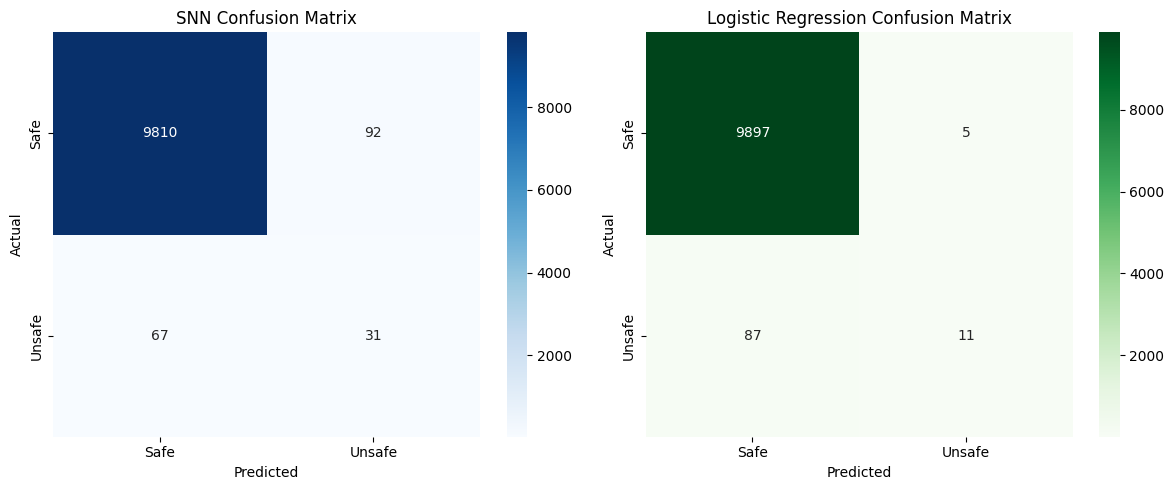

In [ ]:
def main():
    input_file = '/content/Darknet.CSV'
    cleaned_file = '/content/Darknet_cleaned.CSV'
    log_file = '/content/skipped_rows.log'
    if not Path(input_file).exists(): return
    clean_csv(input_file, cleaned_file, log_file)
    if not Path(cleaned_file).exists(): return
    X, y_binary, _ = load_dataset(cleaned_file, log_file, sample_n=50000)
    if X is None: return
    X_pca = apply_pca(X, n_components=20)
    X_spikes = encode_to_spikes(X_pca, num_steps=20)
    X_train, X_test, y_train, y_test = train_test_split(X_spikes, y_binary, test_size=0.2, random_state=42, stratify=y_binary)
    model = NeuCubeSNN(num_inputs=X_pca.shape[1], num_hidden=100, num_outputs=2, num_steps=20)
    train_snn(model, X_train, y_train, num_epochs=10)
    acc, prec, rec, f1 = evaluate_snn(model, X_test, y_test)
    print(f"\nSNN Evaluation:\nAccuracy: {acc:.2%}, Precision: {prec:.2%}, Recall: {rec:.2%}, F1-Score: {f1:.2%}")

    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    with torch.no_grad():
        spk_out, mem_out, _ = model(torch.FloatTensor(X_spikes).to(device))
        X_features = mem_out.sum(dim=0).cpu().numpy()

    clf = LogisticRegression(max_iter=1000)
    X_train_features, X_test_features, y_train, y_test = train_test_split(X_features, y_binary, test_size=0.2, random_state=42, stratify=y_binary)
    clf.fit(X_train_features, y_train)
    y_pred = clf.predict(X_test_features)
    print(f"Combined SNN + Logistic Regression Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")

    global global_state
    global_state = {
        'model': model,
        'X_test': X_test,
        'y_test': y_test,
        'clf': clf,
        'X_test_features': X_test_features,
        'label_names': ["Safe", "Unsafe"]
    }

    plot_confusion_matrices()

main()

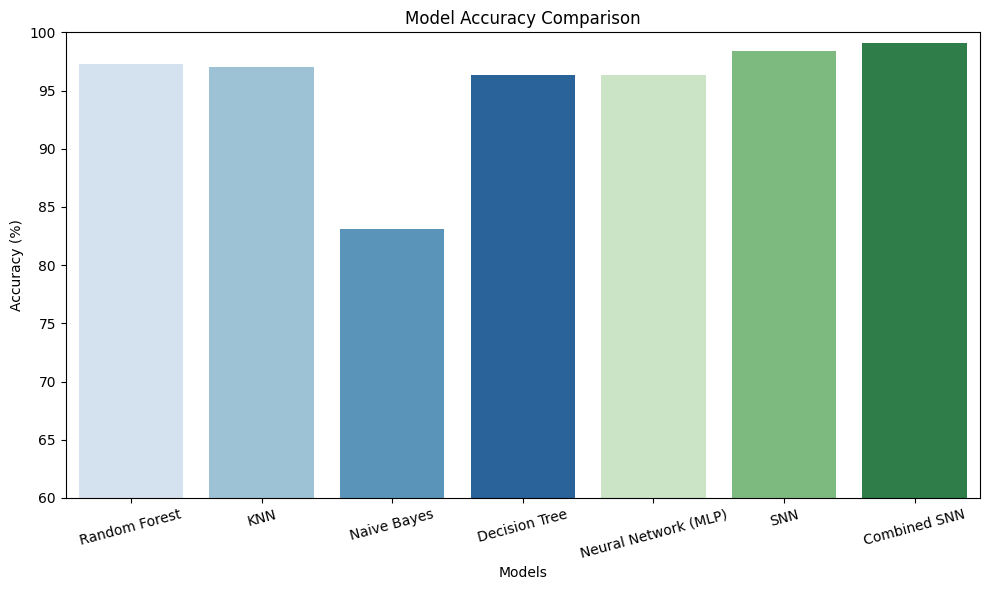

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Store accuracy results
accuracies = {
    "Random Forest": 0.9731,
    "KNN": 0.9706,
    "Naive Bayes": 0.8308,
    "Decision Tree": 0.9632,
    "Neural Network (MLP)": 0.9633,
    "SNN": 0.9838,
    "Combined SNN": 0.9910
}

# Convert accuracies to percentages
accuracies_percent = {k: v * 100 for k, v in accuracies.items()}

# Create a custom palette mixing blue and green
blue_palette = sns.color_palette("Blues", 4)
green_palette = sns.color_palette("Greens", 3)
custom_palette = blue_palette + green_palette  # Combine them

# Plot accuracy comparison
plt.figure(figsize=(10, 6))
sns.barplot(
    x=list(accuracies_percent.keys()),
    y=list(accuracies_percent.values()),
    palette=custom_palette
)
plt.xlabel("Models")
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy Comparison")
plt.ylim(60, 100)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()